In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working in notebook
%matplotlib inline 

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                     test.loc[:,'MSSubClass':'SaleCondition']))

### Data Preprocessing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3b3181350>,
      dtype=object)

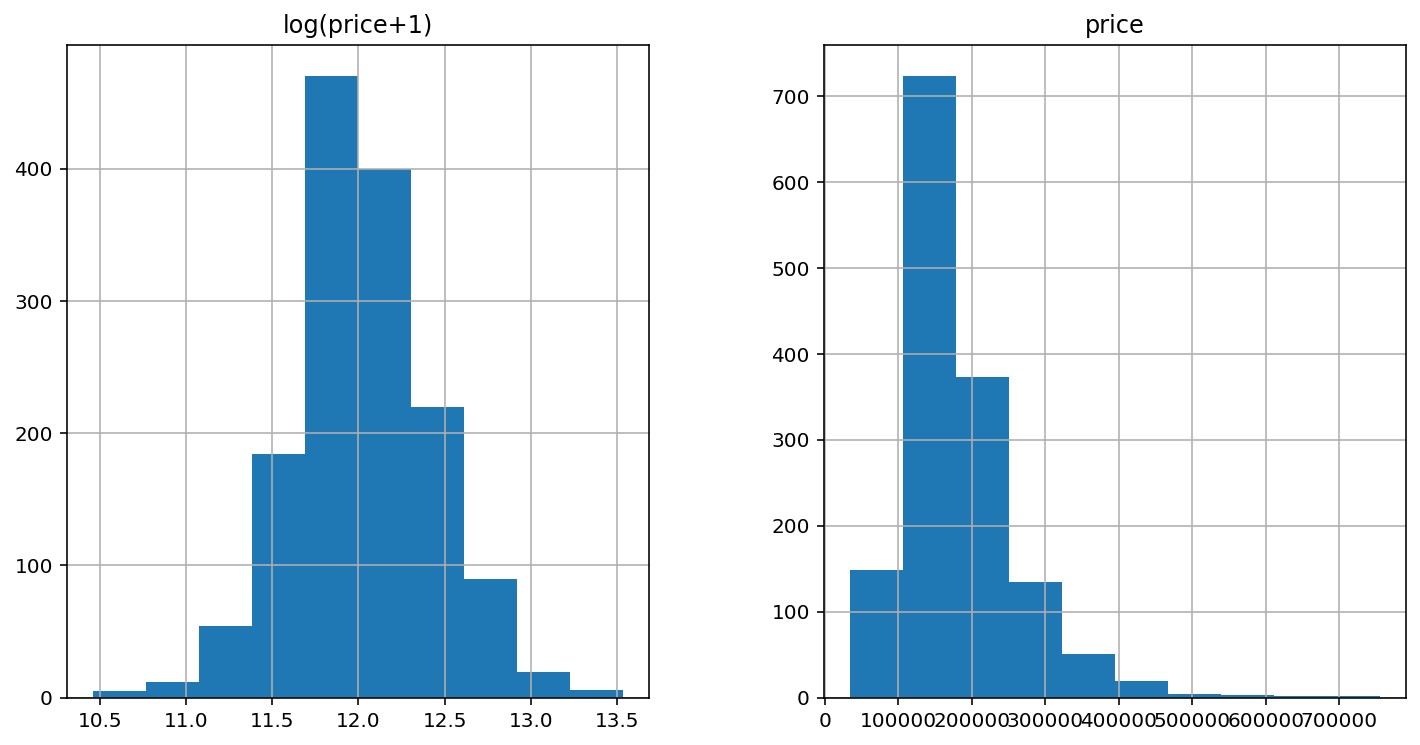

In [10]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({'price':train['SalePrice'],
                       'log(price+1)':np.log1p(train['SalePrice'])})
prices.hist()

In [11]:
#log transform the target
train['SalePrice'] = np.log1p(train['SalePrice'])

#log transform skewed numeric features
numeric_feats = all_data.dtypes[all_data.dtypes!='object'].index

skewed_feats = train[numeric_feats].apply(
    lambda x:skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [12]:
#turn categorical variables to dummy ones
all_data = pd.get_dummies(all_data)

In [13]:
#filling NA's with mean of column
all_data = all_data.fillna(all_data.mean())

In [14]:
#creating matrices for sklearn
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

### Model

Gonna try both L_1(lasso) and L_2(Ridge) Regularizations

In [16]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet,\
    LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, 
                        scoring="neg_mean_squared_error", cv=5))
    return rmse

* cross_val_score has negative in front because the original value returned by the function is negative, coz it's a cost function error, and model would want to maximize its output, so that error can be minimized. So, the negative sign flips it and turns it to positive number. Thus, rmse can be calculated.
* for regression, cross_val_score returns the mse errors
* for classification, it returns accuracy (of course, you have to set the "scoring" parameter in that way

In [17]:
model_ridge = Ridge()

In [19]:
#alphas are the regularization parameters
alphas = [0.05,0.1,1,3,5,10,15,30,50,75]

cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]
cv_ridge_nomean = [rmse_cv(Ridge(alpha=alpha)) for alpha in alphas]

In [20]:
print(cv_ridge)

[0.1389363769402437, 0.13777538277187826, 0.13136184989399574, 0.12864892446111875, 0.12782179689257306, 0.12733734668670757, 0.12752940439753807, 0.12895888148450088, 0.13099437857191387, 0.13316366423370277]


In [21]:
print(cv_ridge_nomean)

[array([0.12332586, 0.14541962, 0.15403882, 0.11276692, 0.15913067]), array([0.12156718, 0.14425787, 0.1516712 , 0.11267361, 0.15870705]), array([0.11383481, 0.13876091, 0.13696888, 0.11193148, 0.15531317]), array([0.11195751, 0.13694414, 0.13009049, 0.11084933, 0.15340316]), array([0.11151436, 0.1365423 , 0.12790036, 0.11043901, 0.15271296]), array([0.11116   , 0.13661429, 0.12633911, 0.11040789, 0.15216544]), array([0.11123938, 0.13708973, 0.12630895, 0.11083927, 0.15216969]), array([0.11246473, 0.13884872, 0.12787247, 0.11262499, 0.1529835 ]), array([0.11456289, 0.14098763, 0.13017732, 0.11491221, 0.15433184]), array([0.11693963, 0.14319487, 0.13250521, 0.11733407, 0.15584454])]


Text(0, 0.5, 'rmse')

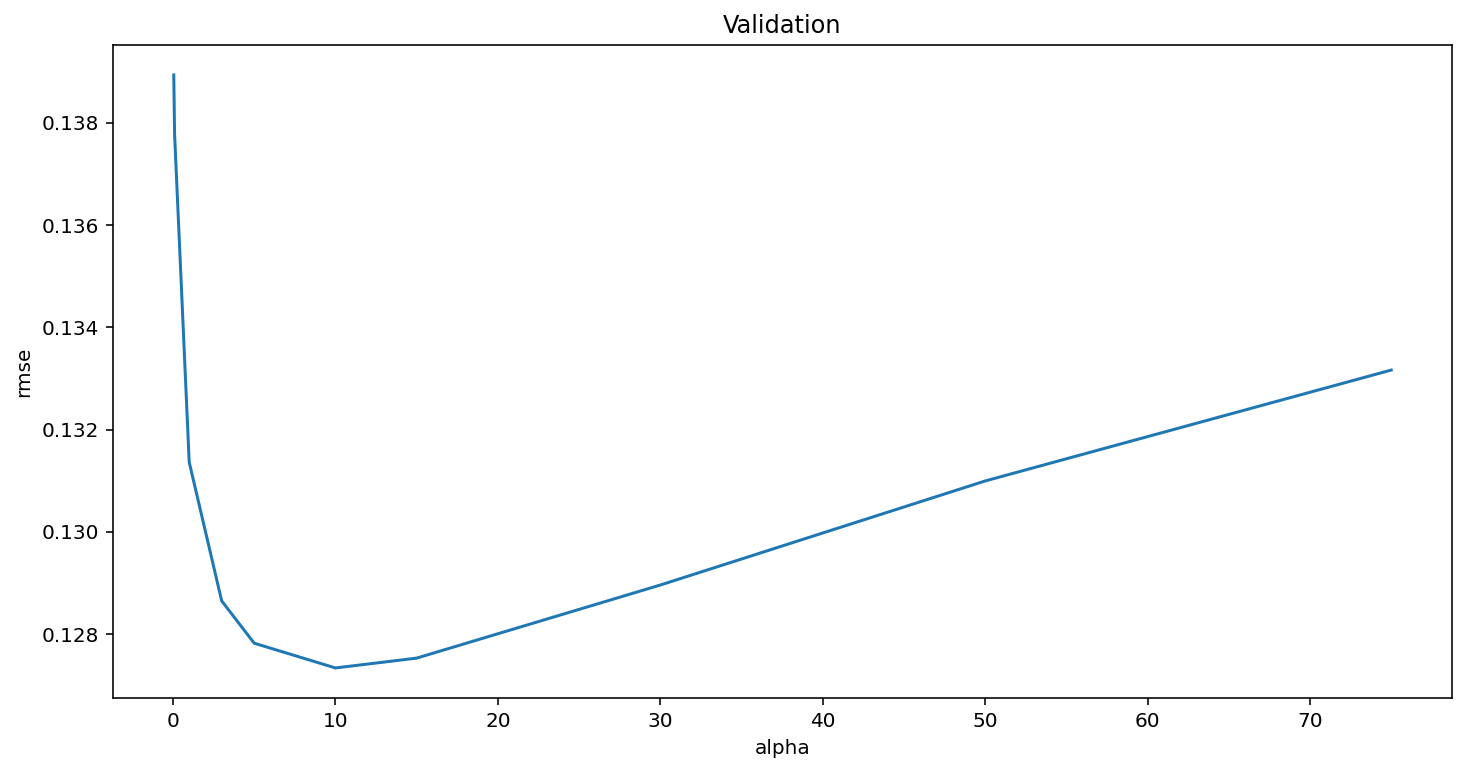

In [25]:
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title="Validation")
plt.xlabel('alpha')
plt.ylabel('rmse')

* So for a value of alpha=10, we get minimum value

In [26]:
cv_ridge.min()

0.12733734668670757

**So for Ridge Regression, at alpha=10, minimum rmse value is 0.127**